# Create HDF5 DataFrame for S values from alphawave FEKO files
see: http://www.h5py.org/

+ This notebook was based on `RFcalcUC_v8.py` module
+ It is used for the **TE-007** spatial averaging working group calculations

## Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.interpolate import interp1d, interp2d, griddata
from icecream import ic
import warnings

import seaborn as sn
sn.set()
%matplotlib inline

# Set current working directory to the notebook folder
%cd -0

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks


## Functions

In [2]:
def h5store(filename, df, **kwargs):
    '''Save a DF with its metadata to a HDF5 file
       see: http://stackoverflow.com/questions/29129095/save-additional-attributes-in-pandas-dataframe
       INPUTS:
         filename = filename of the hdf5 file, including .hdf5 extension
               df = dataframe to be saved as hdf5 store
           kwargs = dict of metadata to store with the dataframe'''
    
    store = pd.HDFStore(filename)
    store.put('mydata', df)
    store.get_storer('mydata').attrs.metadata = kwargs
    store.close()   

def getgrid(df):
    '''Create a dataframe of a grid's characteristics:
       min, max, n, delta'''
    
    def n(arr):
        '''Return number of unique elements in array'''
        return arr.unique().size

    def delta(arr):
        '''Return dx, dy or dz increment between x, y or z points'''
        return np.diff(np.sort(np.unique(arr))).max()
   
    grid = df[['x','y','z']].agg(['min','max',n,delta]).T
    grid['n'] = grid.n.astype(int)
    return grid

def dB(x):
    return 10. * np.log10(x)

def make_mgrid(df,c):
    '''Make an xyz mgrid for column c'''
    df = df.sort_values(['x','y','z'])
    nx = len(df.x.unique())
    ny = len(df.y.unique())
    nz = len(df.z.unique())
    C = df[c].values.reshape(nx, ny, nz)
    return C

def make_mgrid2(df):
    df = df.sort_values(['x','y','z'])
    nx = len(df.x.unique())
    ny = len(df.y.unique())
    nz = len(df.z.unique())
    X = df.x.values.reshape(nx, ny, nz)
    Y = df.y.values.reshape(nx, ny, nz)
    Z = df.z.values.reshape(nx, ny, nz)
    return X, Y, Z, nx, ny, nz

def compliance_zone(df, dat, lim, title =''):
    '''Generate a mayavi 3D compliamce zone
       df = source dataframe, e.g. S, SARdf
      dat = data column, e.g. 'SE', 'SARwb'
      lim = limit value for compliance zone'''

    # Generate mgrids for xyz and data
    X = make_mgrid(df,'x')
    Y = make_mgrid(df,'y')
    Z = make_mgrid(df,'z')
    F = make_mgrid(df,dat)

    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(1200,900), bgcolor=(0.5, 0.5, 0.5))
    mlab.clf()

    # draw the iso-surfaces
    src = mlab.pipeline.scalar_field(X, Y, Z, F, name=dat)
    mlab.pipeline.iso_surface(src, contours=[lim,], opacity=0.5)
    mlab.axes(x_axis_visibility=True, y_axis_visibility=True,
              z_axis_visibility=True, line_width=1)
    
    # print plot title
    height, size = 0.85, 0.5
    mlab.title(title, height=height, size=size)

    mlab.show()

## Look at model metadata for the spatial averaging trials

In [3]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2
INPUT,,,
fMHz,MHz,900,900
antenna,,IEC 62232 panel antenna,IEC 62232 panel antenna
Prad,W,80,80
coordinate_origin,,centre of the middle feed segment,centre of the middle feed segment
xstart,m,0.5,0.5
...,...,...,...
bearing,,main beam along x axis,main beam along x axis
antenna_folder,,MBSpanel,MBSpanel
FEKO_Efile,,IEC-62232-panel-antenna-standard-mesh_Grid3DFE.efe.zip,IEC-62232-panel-antenna-standard-mesh_Grid3DFE.efe.zip


## Read in the E and H data from the FEKO zip files

In [5]:
# Set the trial number
trial = 1

In [5]:
# Get E and H FEKO data file locations
t = trials[str(trial)]
datadir = f'../antennas/{t.antenna_folder}/data/'
Efile = t.FEKO_Efile
Hfile = t.FEKO_Hfile

# Read in E-field FEKO data
print(f'{Efile = }')
Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
Edat = Edat.sort_values(['x','y','z'])
display(Edat.head())

# Read in H-field FEKO data
print(f'{Hfile = }')
Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
Hdat = Hdat.sort_values(['x','y','z'])
display(Hdat.head())

# Calculate SE, SH, Smax
SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
Smax = np.max([SE,SH],axis=0)

S = pd.DataFrame(dict(x=Edat.x,y=Edat.y,z=Edat.z,SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
S.head()

Efile = 'IEC-62232-panel-antenna-standard-mesh_Grid3DFE.efe.zip'


,x,y,z,Exr,Exi,Eyr,Eyi,Ezr,Ezi
0,0.5,-7.0,-3.0,0.002143,0.005977,0.348239,0.500341,-0.801133,-1.588188
19176,0.5,-7.0,-2.9,-0.005226,0.004985,-0.034064,0.622484,0.222759,-1.885471
38352,0.5,-7.0,-2.8,-0.008655,-0.001897,-0.386580,0.460931,1.224005,-1.515189
57528,0.5,-7.0,-2.7,-0.005113,-0.009175,-0.526968,0.137047,1.794559,-0.684281
76704,0.5,-7.0,-2.6,0.003041,-0.011303,-0.430148,-0.148068,1.809666,0.204564


Hfile = 'IEC-62232-panel-antenna-standard-mesh_Grid3DFE.hfe.zip'


,x,y,z,Hxr,Hxi,Hyr,Hyi,Hzr,Hzi
0,0.5,-7.0,-3.0,0.002329,0.004434,0.000096,0.000281,0.000050,0.000109
19176,0.5,-7.0,-2.9,-0.000593,0.005296,-0.000076,0.000306,-0.000036,0.000115
38352,0.5,-7.0,-2.8,-0.003431,0.004217,-0.000230,0.000227,-0.000097,0.000061
57528,0.5,-7.0,-2.7,-0.004992,0.001834,-0.000308,0.000084,-0.000102,-0.000014
76704,0.5,-7.0,-2.6,-0.004944,-0.000660,-0.000299,-0.000060,-0.000058,-0.000062


,x,y,z,SE,SH,Smax
0,0.5,-7.0,-3.0,0.004689,0.004748,0.004748
1,0.5,-7.0,-2.9,0.005296,0.005374,0.005374
2,0.5,-7.0,-2.8,0.005512,0.005594,0.005594
3,0.5,-7.0,-2.7,0.005286,0.005353,0.005353
4,0.5,-7.0,-2.6,0.004674,0.004708,0.004708


## Get antenna pattern data 

In [6]:
horiz_pattern_file = 'IEC-62232-panel-antenna_horCutFF.ffe'
vert_pattern_file = 'IEC-62232-panel-antenna_verCutFF.ffe'
Enames2 = ["theta","phi","Re_Etheta","Im_Etheta","Re_Ephi","Im_Ephi","directivity_theta","directivity_phi","directivity_total"]
hpat = pd.read_csv(datadir + horiz_pattern_file, sep='\s+', skiprows=17, names=Enames2)
vpat = pd.read_csv(datadir + vert_pattern_file, sep='\s+', skiprows=17, names=Enames2)
hpat.name = 'horizontal pattern'
vpat.name = 'vertical pattern'
cols = ['theta','phi','directivity_total']
print(hpat.name)
display(hpat.agg([min,max])[cols])
print(vpat.name)
display(vpat.agg([min,max])[cols])

horizontal pattern


,theta,phi,directivity_total
min,90.0,-89.0,5.115236
max,90.0,90.0,17.031841


vertical pattern


,theta,phi,directivity_total
min,1.0,0.0,-106.570073
max,180.0,0.0,17.031841


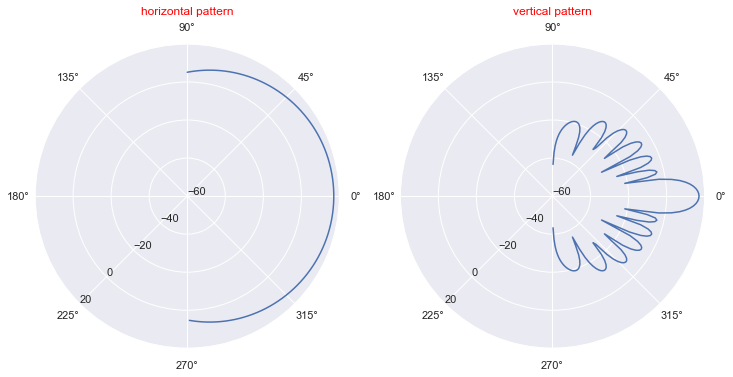

In [7]:
# Plot the horizontal and vertical antenna patterns
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6),
                       subplot_kw={'projection': 'polar'})
rticks = np.arange(-60,40,20)

for i, (df,angle) in enumerate(zip([hpat,vpat],['phi','theta'])):
    theta = df[angle] * np.pi / 180
    if 'vert' in df.name:
        theta = theta - np.pi/2 
    r = df.directivity_total
    ax[i].plot(theta, r)
    ax[i].set_rmax(rticks.max())
    ax[i].set_rmin(rticks.min())
    ax[i].set_rticks(rticks)
    ax[i].set_rlabel_position(225)  # Move radial labels away from plotted line
    ax[i].grid(True)
    ax[i].set_title(df.name, c='red', va='bottom');

## Get SAR data
This version only **interpolates** the SAR values

### Read in Danie's SAR data file

In [8]:
SARdf = pd.read_excel(datadir + 'wbSAR-grid-values.xlsx',usecols="A,B,C,E")
SARdf.head()

,x,y,z,SARwb
0,0.5,0,-2,0.00414
1,0.5,0,-1,0.27674
2,0.5,0,0,0.80114
3,0.5,0,1,0.33776
4,0.5,0,2,0.00656


### Get characterstics of the S and SARdf grids

In [9]:
SARgrid = getgrid(SARdf)
Sgrid = getgrid(S)
display('SAR grid',SARgrid)
display('S grid',Sgrid)

'SAR grid'

,min,max,n,delta
x,0.5,12.5,13,1.0
y,0.0,6.0,7,1.0
z,-2.0,2.0,5,1.0


'S grid'

,min,max,n,delta
x,0.5,14.0,136,0.1
y,-7.0,7.0,141,0.1
z,-3.0,3.0,61,0.1


### Fill out the y<0 symmetry plane data

In [10]:
SARdfm = SARdf.copy()    # mirror copy
SARdfm['y'] = -SARdfm.y  # mirror the y values
SARdfall = pd.concat([SARdf, SARdfm])
SARdfall = SARdfall.drop_duplicates().sort_values(['x','y','z']).reset_index(drop=True)
SARdfall = SARdfall.astype({'y': 'float64','z':'float64'})

# check y symmetry for fixed x & z coordinates
mask = (SARdfall.x == 12.5) & (SARdfall.z == 2) 
SARdfall[mask]

,x,y,z,SARwb
784,12.5,-6.0,2.0,0.00240
789,12.5,-5.0,2.0,0.00250
794,12.5,-4.0,2.0,0.00261
799,12.5,-3.0,2.0,0.00271
804,12.5,-2.0,2.0,0.00279
809,12.5,-1.0,2.0,0.00285
814,12.5,0.0,2.0,0.00286
819,12.5,1.0,2.0,0.00285
824,12.5,2.0,2.0,0.00279
829,12.5,3.0,2.0,0.00271


### Display SARdfall isocontour

In [11]:
compliance_zone(df=SARdfall,dat='SARwb',lim=0.04,title='interpolated SARdfall values on 1m mesh')

### Interpolation functions

In [6]:
def axisvals(axis, delta, df):
    '''Generate points for axis in df for delta increment'''
    minval = df[axis].min()
    maxval = df[axis].max()
    return np.arange(minval, maxval+delta, delta).round(8)

def SARinterpolator1d(df, ax1, newaxisvals, kind):
    '''Interpolate SARwb values in df along specified x, y or z axis
    INPUTS:
      df = input dataframe
      ax1 = axis to intepolate along [x, y or z]
      newaxisvals = interpolation points along the ax1 axis
      kind = type of interpolation [linear, quadractic, cubic, etc]
    OUTPUTS:
      df1 = dataframe with interpolated SARwb values
      '''
    # Get axis names for ax2, ax3
    other_axes = dict(x=('y','z'),y=('x','z'),z=('x','y'))
    ax2, ax3 = other_axes[ax1]
    
    # Create empty dataframe
    df1 = pd.DataFrame(columns=('x','y','z','SARwb')) # initialise empty dataframe
    
    # Groupby over ax2 and ax3 axes
    for (ax2val,ax3val), g in df.groupby([ax2, ax3]):
        
        # Create 1d interpolation function
        xx = g[ax1].values.astype(float)
        yy = np.log10(g.SARwb.values).astype(float)
        f = interp1d(xx, yy, kind=kind)
        ff = lambda newaxisvals: 10**f(newaxisvals)
    
        # do interpolation over ax1 axis
        SARwb = ff(newaxisvals)
        dfi = pd.DataFrame({ax1:newaxisvals, ax2:ax2val, ax3:ax3val, 'SARwb':SARwb})
        df1 = pd.concat([df1, dfi])
        
    df1.sort_values(['x','y','z'],inplace=True)
    
    return df1

### Interpolate SARdfall over x, y & z axes

In [13]:
# Set interpolation parameters
delta = 0.1                            # increment axis points
xnew = axisvals('x', delta, SARdfall)  # new x-value interpolation points
ynew = axisvals('y', delta, SARdfall)  # new y-value interpolation points
znew = axisvals('z', delta, SARdfall)  # new z-value interpolation points

# Conduct x, y and z axis interpolations
SARdfi_x = SARinterpolator1d(SARdfall,'x',xnew,'quadratic')
SARdfi_xy = SARinterpolator1d(SARdfi_x,'y',ynew,'quadratic')
SARdfi_xyz = SARinterpolator1d(SARdfi_xy,'z',znew,'quadratic')

# Rename SARwb to SARwbi
SARdfi_xyz.rename(columns={'SARwb':'SARwbi'},inplace=True)
display(SARdfi_xyz)

# Show SAR grid parameters
getgrid(SARdfi_xyz)

,x,y,z,SARwbi
0,0.5,-6.0,-2.0,0.000250
1,0.5,-6.0,-1.9,0.000328
2,0.5,-6.0,-1.8,0.000426
3,0.5,-6.0,-1.7,0.000548
4,0.5,-6.0,-1.6,0.000696
...,...,...,...,...
36,12.5,6.0,1.6,0.005066
37,12.5,6.0,1.7,0.004271
38,12.5,6.0,1.8,0.003562
39,12.5,6.0,1.9,0.002939


,min,max,n,delta
x,0.5,12.5,121,0.1
y,-6.0,6.0,121,0.1
z,-2.0,2.0,41,0.1


### Display SARdfi_xyz isocontour

In [14]:
compliance_zone(df=SARdfi_xyz,dat='SARwbi',lim=0.04,
                title=f'interpolated SARdfi_xyz values on {delta}m mesh')

### Check symmetry of SARdfi_xyz in the z direction

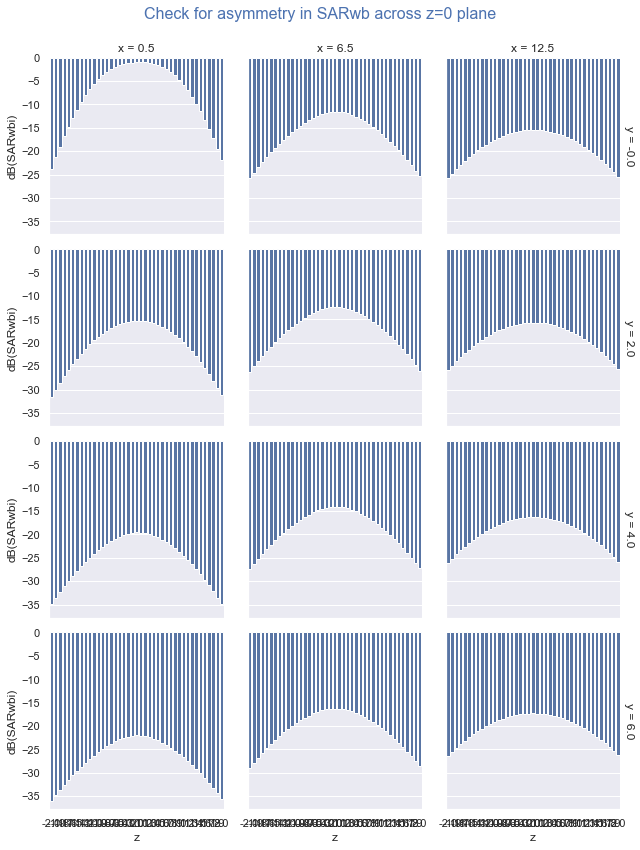

In [17]:
# Bar plots of dB(SARwb) along z for various values of x and y
SARdfi = SARdfi_xyz.copy()
SARdfi['dB(SARwbi)'] = dB(SARdfi.SARwbi)
xvals = [0.5,6.5,12.5]
yvals = [0,2,4,6]

mask = (SARdfi.x.isin(xvals)) & (SARdfi.y.isin(yvals))
g = sn.FacetGrid(SARdfi[mask], col="x", row="y",margin_titles=True)
g.map(sn.barplot, 'z', "dB(SARwbi)", order=np.sort(SARdfi_xyz.z.unique()))
plt.suptitle(f"Check for asymmetry in SARwb across z=0 plane\n",fontsize=16,c='b')
plt.tight_layout();

Data looks nicely symmetric in the z axis. It is *not* expected to be perfectly symmetric since the body phantom is not totally symmetric in the z direction

### Merge SARdf and SARdfi_xyz with S

In [18]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdfall, how='outer')
Sall = Sall.merge(SARdfi_xyz, how='outer')
Sall

,x,y,z,SE,SH,Smax,SARwb,SARwbi
0,0.5,-7.0,-3.0,0.004689,0.004748,0.004748,NaN,NaN
1,0.5,-7.0,-2.9,0.005296,0.005374,0.005374,NaN,NaN
2,0.5,-7.0,-2.8,0.005512,0.005594,0.005594,NaN,NaN
3,0.5,-7.0,-2.7,0.005286,0.005353,0.005353,NaN,NaN
4,0.5,-7.0,-2.6,0.004674,0.004708,0.004708,NaN,NaN
...,...,...,...,...,...,...,...,...
1169731,14.0,7.0,2.6,0.025416,0.025174,0.025416,NaN,NaN
1169732,14.0,7.0,2.7,0.021783,0.021605,0.021783,NaN,NaN
1169733,14.0,7.0,2.8,0.019616,0.019496,0.019616,NaN,NaN
1169734,14.0,7.0,2.9,0.018479,0.018413,0.018479,NaN,NaN


### Compare histogram of Danie's SARwb values with my log-quadratic interpolated values (SARwbi)

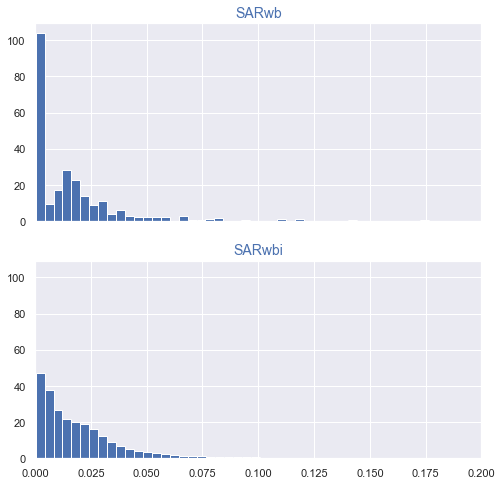

In [19]:
fig, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(8, 8))
bins = 200
Sall.SARwb.hist(bins=bins,ax=ax[0],density=True)
Sall.SARwbi.hist(bins=bins,ax=ax[1],density=True)
ax[0].set_title('SARwb',fontsize=14,color='b')
ax[1].set_title('SARwbi',fontsize=14,color='b');
plt.xlim(0,0.2);

Danie's SAR data and my interpolated data have similar histogram distributions

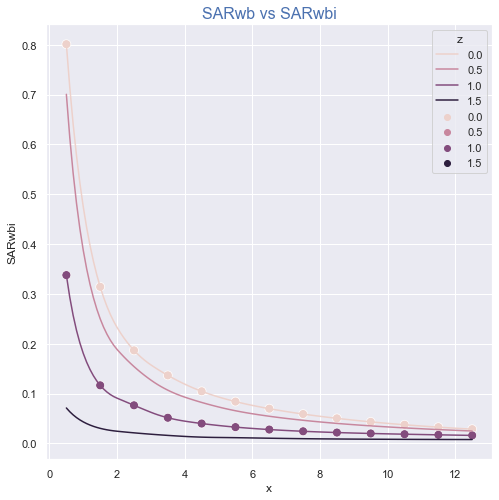

In [20]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
mask = (Sall.y == 0) & (Sall.z.isin([0,.5,1,1.5])) & (Sall.SARwbi != -100)
Sall[mask]
sn.lineplot(data=Sall[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=Sall[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_title('SARwb vs SARwbi', fontsize=16, color='b');

Danie's SAR points (`SARwb`) all lie on the lines for my log-linear interpolated data (`SARwbi`)

## Metadata for Sall dataframe 

In [21]:
# Create dict for S column name metadata
Snames = {'SE': 'S(E) levels',
          'SH': 'S(H) levels',
          'Smax': 'Smax levels',
          'SARps': 'peak spatial SAR',
          'SARwb': 'WBA SAR',
          'SARwbi': 'WBA SAR (interpolated)',
         }

## Save the S DataFrame as hdf5 store with metadata

In [22]:
# Set the file name of the hdf5 store
Sfile = datadir + f'{t.antenna_folder}.hdf5'

# Save the data into an hdf5 store (without x,y,z data)
Sdata = Sall.drop(columns=['x','y','z'])
h5store(Sfile, Sdata, **Snames)
print(f'S DataFrame saved to: {Sfile}')
print(f'len(S) = {len(S):,d}')

S DataFrame saved to: ../antennas/MBSpanel/data/MBSpanel.hdf5
len(S) = 1,169,736


## Scratch

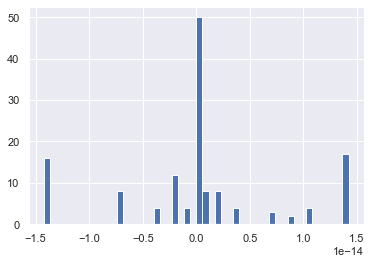

In [25]:
# test if SARinterpolator1d will properly interpolate along an uneven x-axis 
xlist = [1,2,4,8]
ylist = range(-3,4)
zlist = range(-2,3)
listxyz = [(x,y,z) for x in xlist for y in ylist for z in zlist]
df = pd.DataFrame(listxyz,columns=('x','y','z')).astype(float)
df['SARwb'] = df.x**2 + df.y**2 + df.z**2

newxvals = np.arange(1,8.2,0.2).round(1)
dfi = SARinterpolator1d(df, 'x', newxvals, 'quadratic')
dfm = df.merge(dfi, on=('x','y','z'),suffixes=('','i'))
(dfm.SARwb - dfm.SARwbi).hist(bins=50);

*yes it does!*

### Get SAR data I
First attempt at SAR data interpolation and extrapolation

#### Read in Danie's SAR data file

In [24]:
SARdf1 = pd.read_excel(datadir + 'wbSAR-grid-values.xlsx',usecols="A,B,C,E")
getgrid(SARdf1)

,min,max,n,delta
x,0.5,12.5,13,1.0
y,0.0,6.0,7,1.0
z,-2.0,2.0,5,1.0


#### Fill out the y<0 symmetry plane data

In [25]:
SARdf2 = SARdf1.copy()
SARdf2['y'] = -SARdf1.y
SARdf = pd.concat([SARdf1,SARdf2])
SARdf = SARdf.drop_duplicates().sort_values(['x','y','z']).reset_index(drop=True)
SARdf = SARdf.astype({'y': 'float64','z':'float64'})
SARdf['dB(SARwb)'] = dB(SARdf.SARwb)

# check y symmetry for fixed x & z coordinates
mask = (SARdf.x == 12.5) & (SARdf.z == 2) 
SARdf[mask]

,x,y,z,SARwb,dB(SARwb)
784,12.5,-6.0,2.0,0.00240,-26.197888
789,12.5,-5.0,2.0,0.00250,-26.020600
794,12.5,-4.0,2.0,0.00261,-25.833595
799,12.5,-3.0,2.0,0.00271,-25.670307
804,12.5,-2.0,2.0,0.00279,-25.543958
809,12.5,-1.0,2.0,0.00285,-25.451551
814,12.5,0.0,2.0,0.00286,-25.436340
819,12.5,1.0,2.0,0.00285,-25.451551
824,12.5,2.0,2.0,0.00279,-25.543958
829,12.5,3.0,2.0,0.00271,-25.670307


#### Check symmetry in the z direction

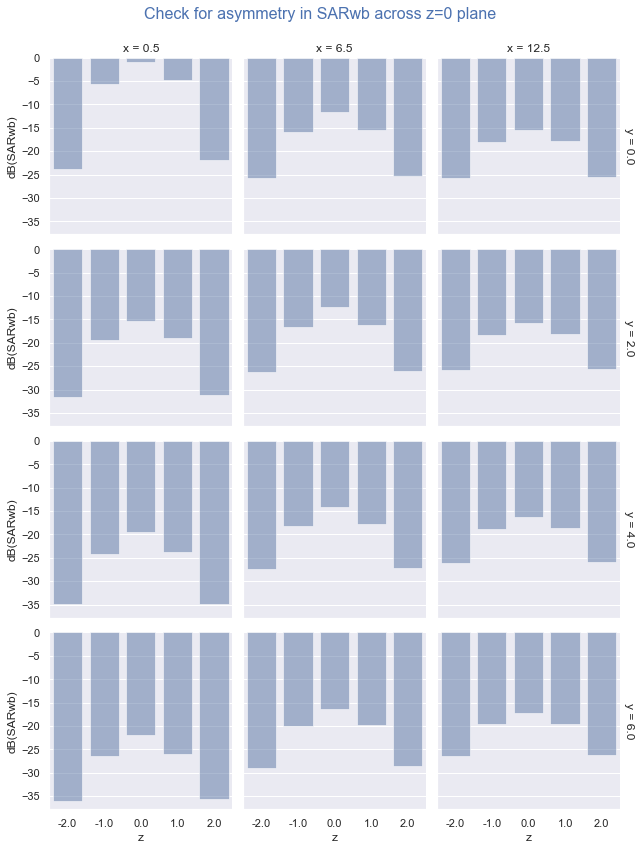

In [26]:
# Bar plots of dB(SARwb) along z for various values of x and y
xvals = [0.5,6.5,12.5]
yvals = [0,2,4,6]
mask = (SARdf.x.isin(xvals)) & (SARdf.y.isin(yvals))
# display(SARdf[mask])
g = sn.FacetGrid(SARdf[mask], col="x", row="y",margin_titles=True)
g.map(sn.barplot, "z", "dB(SARwb)", alpha=.5, order=np.sort(SARdf.z.unique()))
plt.suptitle("Check for asymmetry in SARwb across z=0 plane\n",fontsize=16,c='b')
plt.tight_layout();

#### Expand Danie's SAR grid to match S grid

In [27]:
# Get characterstics of the S and SARdf grids
SARgrid = getgrid(SARdf)
Sgrid = getgrid(S)
display('SAR grid',SARgrid)
display('S grid',Sgrid)

'SAR grid'

,min,max,n,delta
x,0.5,12.5,13,1.0
y,-6.0,6.0,13,1.0
z,-2.0,2.0,5,1.0


'S grid'

,min,max,n,delta
x,0.5,14.0,136,0.1
y,-7.0,7.0,141,0.1
z,-3.0,3.0,61,0.1


In [ ]:
# Functions to extrapolate SARdf grid over nominated axis
def log_extrapolate(arr,xnew,axis,kind):
    '''log10 extrapolation of arr['SARwb'] values of specified kind
       for xnew points along the nominated x, y or z axis'''
    x = arr[axis]
    y = np.log10(arr['SARwb'])
    f = interp1d(x,y,kind=kind)
    ynew = 10**f(xnew)
    df = pd.DataFrame({axis:xnew,'SARwb':ynew})
    return df

def extendSAR(axis,pointvals,kind,df=SARdf):
    '''log10 extrapolation of the SARdf[col] values for the  
       pointvals in the nominated axis direction'''
    # Set the groupby axes
    GBAXES = dict(x=['y','z'],y=['x','z'],z=['x','y'])
    gbaxes = GBAXES[axis]
    
    # Iterate extrapolations over groupby axes 
    dfe = df.groupby(gbaxes).apply(log_extrapolate,xnew=pointvals,axis=axis,kind=kind)
    dfe = dfe.reset_index().drop(columns='level_2')
    return dfe

In [ ]:
# Test out extendSAR for interpolations
axis = 'x'
pointvals = [2,6]

dfi = extendSAR(axis,pointvals,'linear')
dfi.rename(columns={'SARwb':'SARwb_linear'},inplace=True)
for kind in ['quadratic','cubic']:
    df = extendSAR(axis,pointvals,kind)
    colname = f'SARwb_{kind}'
    dfi[colname] = df.SARwb

dfi.head(20)

The quadratic and cubic interpolations are very close

In [ ]:
# Set x and y investigation points
xvals = [0.5,6.5,12.5]
yvals = [0,2,4,6]
zvals = S.z.unique()
nx = len(xvals)
ny = len(yvals)

# Create plot
fig, ax = plt.subplots(ny,nx,figsize=(12,14),sharex=True,sharey=True)

# Iterate over the x and y investigation points
for i, x in enumerate(xvals):
    for j, y in enumerate(yvals):
        mask = (SARdf.x == x) & (SARdf.y == y)
        ax[j,i].plot(SARdf[mask].z, dB(SARdf[mask].SARwb),'o')
        ax[j,i].set_title(f'x = {x}  |  y = {y}',fontsize=14,c='b')

        # Plot the interpolated  dB(SAR) points
        for kind in ['linear','quadratic','cubic']:
            dfi = extendSAR('z',zvals,kind,df=SARdf[mask])
            ax[j,i].plot(dfi.z, dB(dfi.SARwb),'-',label=kind)
            
        ax[j,i].set_xlabel('z')
        ax[j,i].set_ylabel('dB(SAR)')

ax[-1,-1].legend(loc='lower center',fontsize=14)
fig.suptitle('Interpolation of dB(SAR) values along z axis for different kinds of schemes\n',
             fontsize=20)
plt.tight_layout()


The extrapolated parts of the <font color='green'>quadratic</font> and <font color='red'>cubic</font> plots are generally close to each other. 

In that case it would be better to stick with the **quadratic** scheme since it is less 'dangerous' for extrapolation. Indeed, using the cubic scheme in the cell below leads to artifactual peaks in the upper far corners of the SAR plots.

In [ ]:
SARdfe = SARdf.drop(columns="dB(SARwb)").copy()

# set up extrapolation/interpolation parameters
kind = 'quadratic'
# kind = 'cubic'
# kind = 'linear'
zvals = [-3, 3]
yvals = [-7, 7]
xvals = sorted(list(set(S.x.values) - set(SARdfe.x.values)))

# extend SARdfe by extrapolating over the y axis
dfe = extendSAR('y',yvals,kind,df=SARdfe)
SARdfe = pd.concat([SARdfe, dfe]).sort_values(['x','y','z'])

# extend SARdfe by extrapolating over the z axis
dfe = extendSAR('z',zvals,kind,df=SARdfe)
SARdfe = pd.concat([SARdfe, dfe]).sort_values(['x','y','z'])

# extend SARdfe by extrapolating over the x axis
dfe = extendSAR('x',xvals,kind,df=SARdfe)
SARdfe = pd.concat([SARdfe, dfe]).sort_values(['x','y','z'])

# Create dBSAR
SARdfe['dBSARwb'] = dB(SARdfe.SARwb)

print('SARdfe grid parameters')
getgrid(SARdfe)

In [ ]:
def SARlines(df,fixedaxis,fixedval,xaxis,legendaxis,SARcol):
    cmap = sn.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
    mask = df[fixedaxis] == fixedval
    sn.relplot(x=xaxis,y=SARcol,kind='line',hue=legendaxis,
               palette=cmap,height=6,data=df[mask])
    title = f'{kind} scheme for {fixedaxis} = {fixedval}'
    plt.suptitle(title,fontsize=16,c='b')
    plt.xlim(df[xaxis].min(),df[xaxis].max())
    plt.tight_layout(rect=(0,0,0.9,1))    

In [ ]:
SARlines(df=SARdfe,fixedaxis='x',fixedval=12.5,
         xaxis='y',legendaxis='z',SARcol='SARwb')

In [ ]:
SARlines(df=SARdfe,fixedaxis='x',fixedval=14,
         xaxis='y',legendaxis='z',SARcol='SARwb')

In [ ]:
SARlines(df=SARdfe,fixedaxis='y',fixedval=0,
         xaxis='x',legendaxis='z',SARcol='dBSARwb')

In [ ]:
SARlines(df=SARdfe,fixedaxis='y',fixedval=7,
         xaxis='x',legendaxis='z',SARcol='dBSARwb')

In [ ]:
# display 3D compliance zone
compliance_zone(df=SARdfe, dat='SARwb', lim=0.015, title='SARwb data in SARdfe')

#### Interpolate SAR values on to S grid using log-linear interpolation

In [14]:
# Interpolate SAR values for xyz points in S using log linear interpolation
SARpoints = SARdf[['x','y','z']].values
Spoints = S[['x','y','z']].values
SARwbi = 10**griddata(SARpoints, np.log10(SARdf.SARwb.values), Spoints)

# Replace nan's in SARwbi with -100
SARwbi = np.nan_to_num(SARwbi, nan=-100)

#### Add SARwb, SARps and SARwbi to Sall

In [15]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdf,how='outer')

# Add SARwbi to Sall
Sall['SARwbi'] = SARwbi

#### Compare histogram of Danie's SARwb values with my log-linear interpolated values (SARwbi)

(0.0, 0.4)

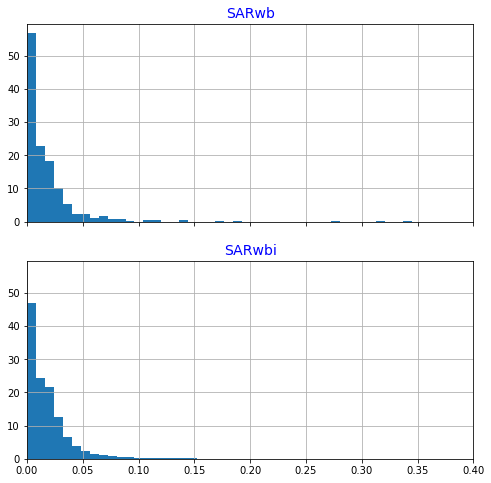

In [19]:
fig, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(8, 8))
bins = 100
Sall.SARwb.hist(bins=bins,ax=ax[0],density=True)
Sall.SARwbi[Sall.SARwbi != -100].hist(bins=bins,ax=ax[1],density=True)
ax[0].set_title('SARwb',fontsize=14,color='b')
ax[1].set_title('SARwbi',fontsize=14,color='b');
plt.xlim(0,0.4)

Danie's SAR data and my interpolated data have very similar histogram distributions

In [ ]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
mask = (Sall.y == 0) & (Sall.z.isin([0,.5,1,1.5])) & (Sall.SARwbi != -100)
Sall[mask]
sn.lineplot(data=Sall[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=Sall[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_title('SARwb vs SARwbi', fontsize=16, color='b');

### Get SAR data II
Second attempt at SAR data interpolation and extrapolation

#### Read in Danie's SAR data file

In [14]:
SARdf = pd.read_excel(datadir + 'wbSAR-grid-values.xlsx',usecols="A,B,C,E")

#### Expand Danie's SAR grid to match S grid

In [15]:
# Get characterstics of the S and SARdf grids
SARgrid = getgrid(SARdf)
Sgrid = getgrid(S)
display('SAR grid',SARgrid)
display('S grid',Sgrid)

'SAR grid'

,min,max,n,delta
x,0.5,12.5,13,1.0
y,0.0,6.0,7,1.0
z,-2.0,2.0,5,1.0


'S grid'

,min,max,n,delta
x,0.5,14.0,136,0.1
y,-7.0,7.0,141,0.1
z,-3.0,3.0,61,0.1


In [10]:
# Functions to extrapolate SARdf grid over nominated axis
def log_extrapolate(arr,xnew,axis,kind):
    '''log10 extrapolation of arr['SARwb'] values of specified kind
       for xnew points along the nominated x, y or z axis'''
    x = arr[axis]
    y = np.log10(arr['SARwb'])
    f = interp1d(x,y,kind=kind,fill_value="extrapolate")
    ynew = 10**f(xnew)
    df = pd.DataFrame({axis:xnew,'SARwb':ynew})
    return df

def extendSAR(axis,pointvals,kind,df=SARdf):
    '''log10 extrapolation of the SARdf[col] values for the  
       pointvals in the nominated axis direction'''
    # Set the groupby axes
    GBAXES = dict(x=['y','z'],y=['x','z'],z=['x','y'])
    gbaxes = GBAXES[axis]
    
    # Iterate extrapolations over groupby axes 
    dfe = df.groupby(gbaxes).apply(log_extrapolate,xnew=pointvals,axis=axis,kind=kind)
    dfe = dfe.reset_index().drop(columns='level_2')
    return dfe

In [11]:
# Test out extendSAR for interpolations
axis = 'x'
pointvals = [2,6]

dfi = extendSAR(axis,pointvals,'linear')
dfi.rename(columns={'SARwb':'SARwb_linear'},inplace=True)
for kind in ['quadratic','cubic']:
    df = extendSAR(axis,pointvals,kind)
    colname = f'SARwb_{kind}'
    dfi[colname] = df.SARwb

dfi.head(20)

,y,z,x,SARwb_linear,SARwb_quadratic,SARwb_cubic
0,0,-2,2,0.003572,0.003571,0.003537
1,0,-2,6,0.002486,0.002486,0.002490
2,0,-1,2,0.087820,0.085037,0.085557
3,0,-1,6,0.027371,0.027194,0.027184
4,0,0,2,0.242299,0.232725,0.233064
5,0,0,6,0.076565,0.076326,0.076337
6,0,1,2,0.094458,0.090820,0.091790
7,0,1,6,0.030232,0.030108,0.030098
8,0,2,2,0.003818,0.003701,0.003665
9,0,2,6,0.002900,0.002945,0.002960


The quadratic and cubic interpolations are very close

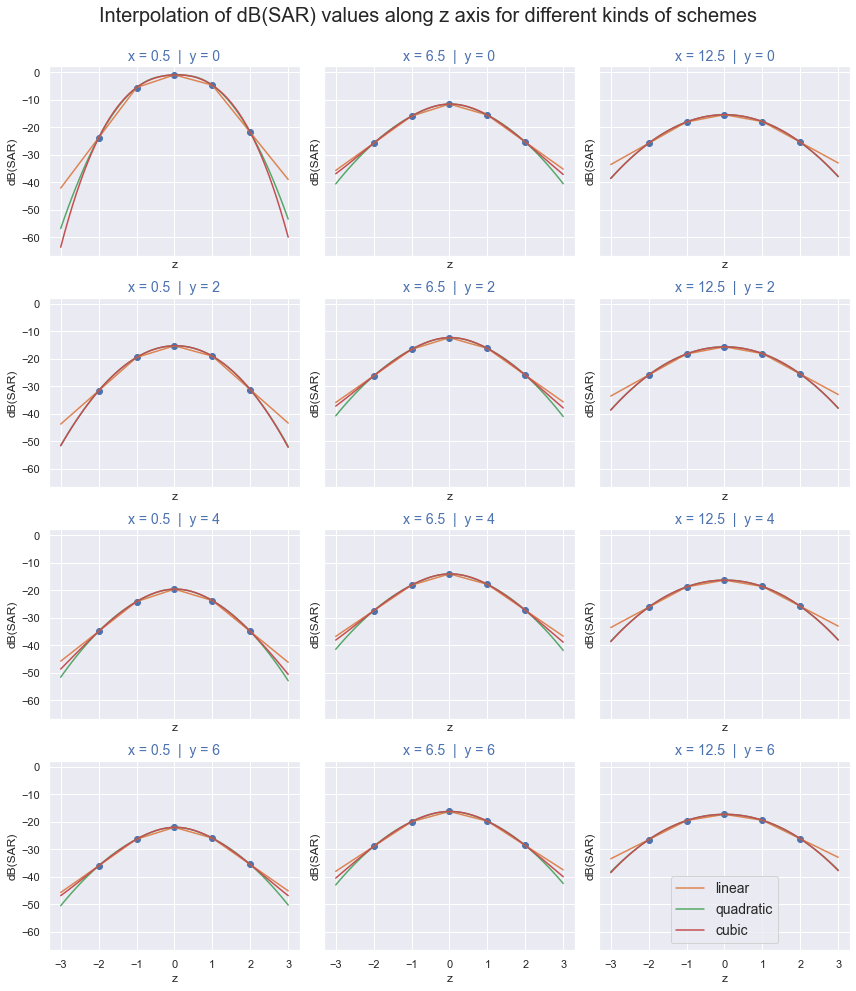

In [12]:
# Set x and y investigation points
xvals = [0.5,6.5,12.5]
yvals = [0,2,4,6]
zvals = S.z.unique()
nx = len(xvals)
ny = len(yvals)

# Create plot
fig, ax = plt.subplots(ny,nx,figsize=(12,14),sharex=True,sharey=True)

# Iterate over the x and y investigation points
for i, x in enumerate(xvals):
    for j, y in enumerate(yvals):
        mask = (SARdf.x == x) & (SARdf.y == y)
        ax[j,i].plot(SARdf[mask].z, dB(SARdf[mask].SARwb),'o')
        ax[j,i].set_title(f'x = {x}  |  y = {y}',fontsize=14,c='b')

        # Plot the interpolated  dB(SAR) points
        for kind in ['linear','quadratic','cubic']:
            dfi = extendSAR('z',zvals,kind,df=SARdf[mask])
            ax[j,i].plot(dfi.z, dB(dfi.SARwb),'-',label=kind)
            
        ax[j,i].set_xlabel('z')
        ax[j,i].set_ylabel('dB(SAR)')

ax[-1,-1].legend(loc='lower center',fontsize=14)
fig.suptitle('Interpolation of dB(SAR) values along z axis for different kinds of schemes\n',
             fontsize=20)
plt.tight_layout()


The extrapolated parts of the <font color='green'>quadratic</font> and <font color='red'>cubic</font> plots are generally close to each other. 

In that case it would be better to stick with the **quadratic** scheme since it is less 'dangerous' for extrapolation. Indeed, using the cubic scheme in the cell below leads to artifactual peaks in the upper far corners of the SAR plots.

In [16]:
SARdfe = SARdf.copy()

# set up extrapolation/interpolation parameters
kind = 'quadratic'
# kind = 'cubic'
# kind = 'linear'
xvals = [13.5]
zvals = [-3,3]
yvals = [7]

# extend SARdfe by extrapolating over the x axis
dfe = extendSAR('x',xvals,kind,df=SARdfe)
SARdfe = pd.concat([SARdfe, dfe]).sort_values(['x','y','z'])

# extend SARdfe by extrapolating over the y axis
dfe = extendSAR('y',yvals,kind,df=SARdfe)
SARdfe = pd.concat([SARdfe, dfe]).sort_values(['x','y','z'])

# extend SARdfe by extrapolating over the z axis
dfe = extendSAR('z',zvals,kind,df=SARdfe)
SARdfe = pd.concat([SARdfe, dfe]).sort_values(['x','y','z'])

# extend SARdfe by interpolating/extrapolating over the x axis
xvals = sorted(list(set(S.x.values) - set(SARdfe.x.values)))
dfe = extendSAR('x',xvals,kind,df=SARdfe)
SARdfe = pd.concat([SARdfe, dfe]).sort_values(['x','y','z'])

# Create dBSAR
SARdfe['dBSARwb'] = dB(SARdfe.SARwb)

print('SARdfe grid parameters')
getgrid(SARdfe)

SARdfe grid parameters


,min,max,n,delta
x,0.5,14.0,136,0.1
y,0.0,7.0,8,1.0
z,-3.0,3.0,7,1.0


In [17]:
def SARlines(df,fixedaxis,fixedval,xaxis,legendaxis,SARcol):
    cmap = sn.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
    mask = df[fixedaxis] == fixedval
    sn.relplot(x=xaxis,y=SARcol,kind='line',hue=legendaxis,
               palette=cmap,height=6,data=df[mask])
    title = f'{kind} scheme for {fixedaxis} = {fixedval}'
    plt.suptitle(title,fontsize=16,c='b')
    plt.xlim(df[xaxis].min(),df[xaxis].max())
    plt.tight_layout(rect=(0,0,0.9,1))    

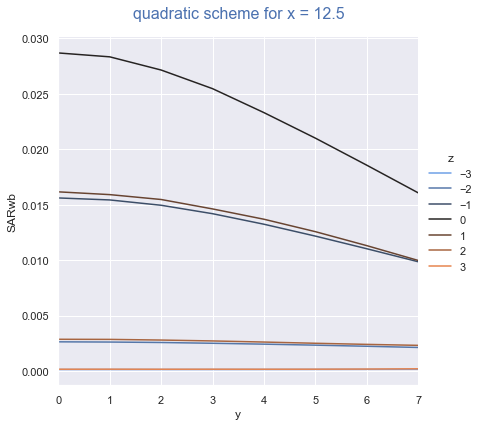

In [18]:
SARlines(df=SARdfe,fixedaxis='x',fixedval=12.5,
         xaxis='y',legendaxis='z',SARcol='SARwb')

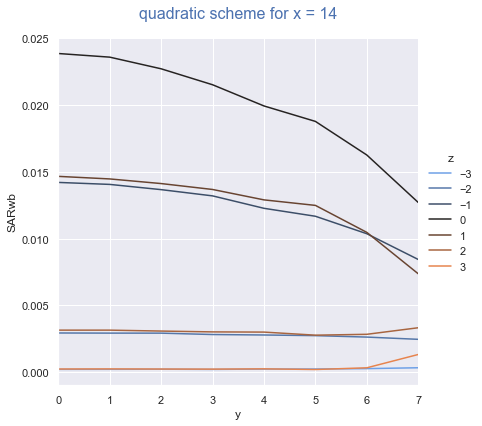

In [19]:
SARlines(df=SARdfe,fixedaxis='x',fixedval=14,
         xaxis='y',legendaxis='z',SARcol='SARwb')

In [22]:
# display 3D compliance zone
compliance_zone(df=SARdfe, dat='SARwb', lim=0.08, title='SARwb data in SARdfe')

#### Fill out the y<0 symmetry plane data

In [23]:
SARdf2 = SARdf.copy()
SARdf2['y'] = -SARdf.y
SARdf3 = pd.concat([SARdf1,SARdf])
SARdf = SARdf.drop_duplicates().sort_values(['x','y','z']).reset_index(drop=True)
SARdf = SARdf.astype({'y': 'float64','z':'float64'})
SARdf['dB(SARwb)'] = dB(SARdf.SARwb)

# check y symmetry for fixed x & z coordinates
mask = (SARdf.x == 12.5) & (SARdf.z == 2) 
SARdf[mask]

NameError: name 'SARdf1' is not defined

#### Check symmetry in the z direction

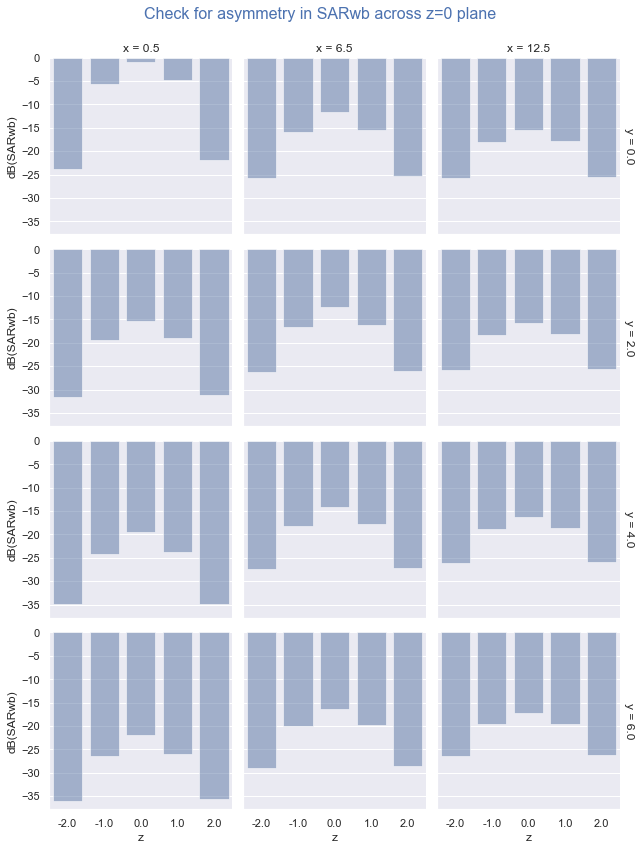

In [35]:
# Bar plots of dB(SARwb) along z for various values of x and y
xvals = [0.5,6.5,12.5]
yvals = [0,2,4,6]
mask = (SARdf.x.isin(xvals)) & (SARdf.y.isin(yvals))
# display(SARdf[mask])
g = sn.FacetGrid(SARdf[mask], col="x", row="y",margin_titles=True)
g.map(sn.barplot, "z", "dB(SARwb)", alpha=.5, order=np.sort(SARdf.z.unique()))
plt.suptitle("Check for asymmetry in SARwb across z=0 plane\n",fontsize=16,c='b')
plt.tight_layout();

#### Interpolate SAR values on to S grid using log-linear interpolation

In [36]:
# Interpolate SAR values for xyz points in S using log linear interpolation
SARpoints = SARdf[['x','y','z']].values
Spoints = S[['x','y','z']].values
SARwbi = 10**griddata(SARpoints, np.log10(SARdf.SARwb.values), Spoints)

# Replace nan's in SARwbi with -100
SARwbi = np.nan_to_num(SARwbi, nan=-100)

#### Add SARwb, SARps and SARwbi to Sall

In [37]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdf,how='outer')

# Add SARwbi to Sall
Sall['SARwbi'] = SARwbi

#### Compare histogram of Danie's SARwb values with my log-linear interpolated values (SARwbi)

(0.0, 0.4)

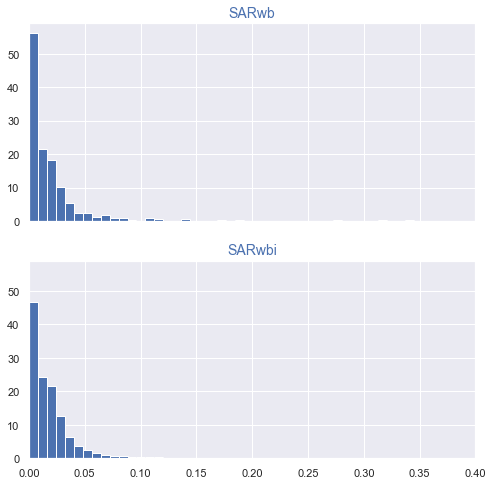

In [38]:
fig, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(8, 8))
bins = 100
Sall.SARwb.hist(bins=bins,ax=ax[0],density=True)
Sall.SARwbi[Sall.SARwbi != -100].hist(bins=bins,ax=ax[1],density=True)
ax[0].set_title('SARwb',fontsize=14,color='b')
ax[1].set_title('SARwbi',fontsize=14,color='b');
plt.xlim(0,0.4)

Danie's SAR data and my interpolated data have very similar histogram distributions

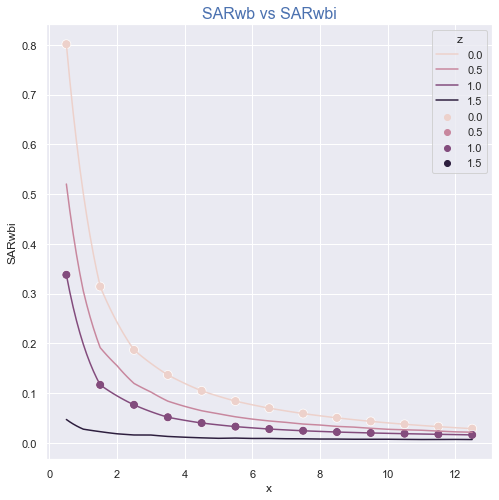

In [39]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
mask = (Sall.y == 0) & (Sall.z.isin([0,.5,1,1.5])) & (Sall.SARwbi != -100)
Sall[mask]
sn.lineplot(data=Sall[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=Sall[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_title('SARwb vs SARwbi', fontsize=16, color='b');